### Directory
- [odds](#odds)
- [think like a data scientist](#tlads)
- [challenge](#challenge)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


As you may recall, one of the requirements of linear regression was a continuous outcome variable, $y$.  Linear regression can be used to predict things like how much money a customer will spend due to a certain promotion, or how happy employees are in reaction to different management styles.  But oftentimes, we are actually interested in predicting the probability of an outcome – whether a customer will buy a product or not, or whether an employee will leave the company or stay.  For situations like those, where the outcome is categorical rather than continuous, we can use logistic regression.  Yes, this means we are using regression as a classifier!

## Logistic regression vs  linear regression

The formula for multivariate linear regression relating outcome $y$ to a matrix of variables $X$ is: 
$$y=\alpha + \beta X$$
You may also see it as $y=\beta X$, where $X$ includes an intercept variable with all values set to 1.  These are equivalent.

The formula for **binary logistic regression** relating $p$ (the probability of getting $y=1$ rather than $y=0$ in outcome variable $y$) to a matrix of variables $X$ is: 
$$ln\left(\dfrac p{1-p}\right)=\beta X$$

If $p$ is the probability of $y=1$, and there are only two possible values for $y$ ($0$ and $1$), then $1-p$ is the probability of $y=0$.  The ratio of $p$ to $1-p$ gives **the odds** of getting $y=1$.  For example, if an unfair coin has an 80% probability of turning up heads, then the odds of getting heads on any given flip are $.8/(1-.8)=4$.  In other words, for any given coin flip, you are four times more likely to get heads than tails.  Conversely, of course, the odds of getting tails are $.2/(1-.2)=.25$.  The convention is to calculate the odds of the more likely outcome over the less likely outcome, as odds less than $1$ (like $.25$) are not very intuitive.

After the transformation, logistic regression and linear regression behave in the same way and follow the same assumptions: _linearity_ (of the transformed probabilities and the predictors), _multivariate normality of the residuals_, _homoscedasticity_ (variance of the residuals is constant across all predicted values), and _low multicollinearity_. 

<a id = 'odds'></a>
### Quick check

What are the odds of getting heads if you flip a fair coin?
<br>p = 0.5
<br>odds = 0.5 / (1 - 0.5) = 1

## Why log?
You will also see $ln\left(\dfrac p{1-p}\right)$ summarized as $logit(p)$.  In either case, it represents the natural log of the odds of getting $y=1$.  We convert our binary outcome $y(0,1)$ into logged odds because regression requires normally distributed residuals, which come from a linear relationship between outcome and predictor. You can't get those from binary outcomes or odds on their own, as we will demonstrate.

First, let's create a continuous variable `x` and a binary variable `y` and graph them:

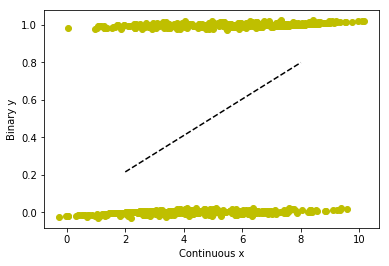

In [2]:
# Set the random seed so that the 'random' data is the same each time
# the code is run.
np.random.seed(seed=456613)

# Create some data.
df = pd.DataFrame()
for probs in list(range(2, 9)):
    tmp = pd.DataFrame({
        'y': np.random.binomial(1, probs / 10, size=(1, 100))[0],
        'x': probs
    }) 
    df = df.append(tmp)

# Continuous predictor.
x = df['x']

# Binary outcome.
bin_y = df['y']

# Calculate linear regression for x and bin_y.
fit = np.polyfit(x,bin_y,1)

# Work as a function to return the predicted value of y.
fit_fn = np.poly1d(fit)

# Add a little 'noise' to the data for graphing purposes.
jitter = np.random.randn(700)

# Display our results.
plt.plot(x + jitter, bin_y + jitter / 100, 'yo', x, fit_fn(x), '--k')
plt.xlabel('Continuous x')
plt.ylabel('Binary y')
plt.show()

While we _could_ fit a linear regression line to this data, you can see that it would be a very poor fit.  A well-fitting regression line will reflect the shape of the data, and this line cannot do that because the binary y only takes two possible values.  The relationship between x and y is very, very non-linear.  If we tried to do regression anyway, it would lead to a very badly fitting model.

Let's try another strategy and convert those binary values into the odds of getting $y=1$ for each value of $x$.

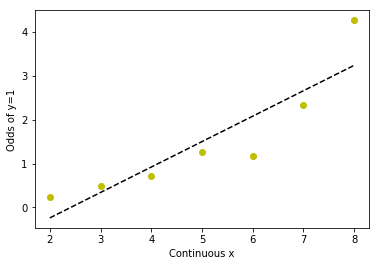

In [3]:
# Unique values in x.
xvals = x.unique()

# Calculate and store the odds.
yodds = []
for xi in xvals: 
    y1_ct = bin_y[x == xi].sum()  # The number of trials y = 1.
    y0_ct = len(bin_y[x == xi]) - y1_ct  # The number of trials y = 0.
    yodds.append(y1_ct / y0_ct)  # Odds of getting y = 1 for xi.
    
# Calculate linear regression for x and yodds.
fit = np.polyfit(xvals, yodds, 1)

# Work as a function to return the predicted value of yodds.
fit_fn = np.poly1d(fit)

# Display our work.
plt.plot(xvals, yodds, 'yo', xvals, fit_fn(xvals), '--k')
plt.xlabel('Continuous x')
plt.ylabel('Odds of y=1')
plt.show()

That's starting to look nicer.

To get the odds, we counted up how many times $y=1$ for each value of $x$ and divided it by the number of times $y=0$.  This gives us the odds of getting $y=1$ for each value of $x$.  The odds are a continuous variable, rather than a binary one. However, as we can see, the relationship between the odds and the continuous $x$ is still not linear – there is variation in the odds that isn't being captured by $x$.

To capture that nonlinearity, we can try a non-linear transformation of the odds variable.

## Linear vs non-linear transformations

A linear transformation is one where the relationship between the original value and the transformed value is the same for all values in a variable.  Addition, subtraction, multiplication, and division are examples of linear transformations:

|x|x+3|x+3-1|x*5|x*4/2|
|-|-|-|-|-|
|1|4|3|5|2|
|2|5|4|10|4|
|3|6|5|15|6|
|4|7|6|20|8|

For the addition example, the input is _always 3 less_ than the output. For the multiplication example, the output _is always 5 times larger_ than the input. 

Not every transformation is linear. Let's look at squaring and logarithms for example.

|x|x<sup>2</sup>|x<sup>2</sup>/x|log<sub>2</sub>(x)|log_x-x|
|-|-|-|-|-|
|1|1|1|0|-1|
|2|4|2|1|-1|
|3|9|3|1.58|-1.42|
|4|16|4|2|-2|

Here a one-unit change in the input ($x$) to the square and log transformations doesn't create same-sized changes in the output.  For the square transformation, the larger the input, the _bigger_ the impact of increasing or decreasing the input by 1.  For the logrithm transformation, the larger the input, the _smaller_ the impact of increasing or decreasing the input by 1 (except for log(1), which is a special case).

## Logarithms to the rescue

Formally, a logarithm is the power to which the base must be raised to produce the number being logged.  For log base 2, the log of 1 is 0, because $2^0=1$.  Similarly, the log of 2 is 1, because $2^1=2$.  The log of 3 is 1.58 (and some more digits) because $2^{1.58...}=3$.

Logarithms are useful when dealing with data where values become more and more widely spaced as they become larger. If you look back to the graph we just made, you'll see that the difference between the odds for $x=7$ and $x=8$ is at least 10 times larger than the difference between $x=1$ and $x=2$.  Logging the odds "shrinks" the values toward zero, with a greater shrinkage factor for larger values.  For us, that means logging the odds has the possibility of evening up the distances between the odds values, leading to a linear relationship with x.

Now let's try taking the log of the odds:

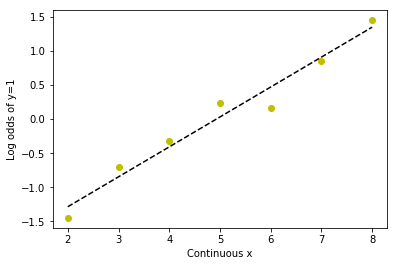

In [4]:
# Natural log of the odds.
ln_yodds = np.log(yodds)

# Calculate linear regression for x and yodds.
fit = np.polyfit(xvals, ln_yodds, 1)

# Works as a function to return the predicted value of yodds.
fit_fn = np.poly1d(fit)

# Display.
plt.plot(xvals, ln_yodds, 'yo', xvals, fit_fn(xvals), '--k')
plt.xlabel('Continuous x')
plt.ylabel('Log odds of y=1')

plt.show()

Now _that_ looks more like a linear relationship, with distances of similar magnitude between the points.  Regression can work with this.  The drawback, of course, is that working with logged odds leads to conclusions like "A 1-year increase in age leads to a 2.2 log-odds increase in the likelihood of having a hearing problem," which is basically gibberish to most people.  As a result, when interpreting individual coefficients from a binary logistic regression, it is customary to back-transform the log-odds into odds by exponentiating ($e^{logit(p)}$), and then interpret the odds.

Note that it is the convention to use the natural log when logging the odds, and therefore the exponentiation uses Euler's number $e$ as the base.

## Thinking Like a Data Scientist

The ability to clearly communicate results like this is a _key skill_ of the data scientist. Your data and models are worthless unless people understand them well enough to act. 

Imagine you ran a binary logistic regression predicting likelihood of developing a hearing problem, using age in years and male (0=female, 1=male) as predictors. Your final model looks like this: 

$$logit(HasHearingProblem) = -1 + .02 * age + 1 * male$$

Write out a description of the effects that age and gender have on the odds of developing hearing problems in terms a layperson could understand.  Include estimates for the odds of hearing problems in a 95 year old woman and a 50 year old man. Discuss your interpretation with your mentor.

<a id = 'tlads'></a>
The intercept has a small impact on the odds of having a hearing problem; it adds 0.3 to the odds. Age is directly proportional to the odds with a coefficient of 1. Males are nearly twice as likely to have a hearing problem.
<br>odds for a 95 year old woman are 2.46
<br>odds for a 50 year old man are 2.72

## Fitting a binary logistic model using statsmodels

Now, let's try fitting our own binary logistic model.  We'll be using a common dataset predicting university admission based on GPA, GRE, and school ranking (from 1, the best, to 4, the worst).

We're using just the 'gpa' and 'gre' variables as predictors for now.

First, we inspect the data:

   admit  gre   gpa  rank
0      0  380  3.61     3
1      1  660  3.67     3
2      1  800  4.00     1
3      1  640  3.19     4
4      0  520  2.93     4


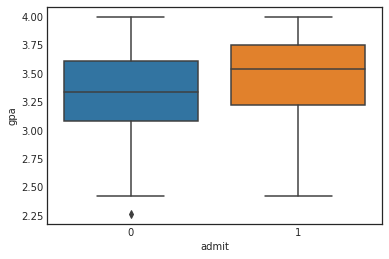

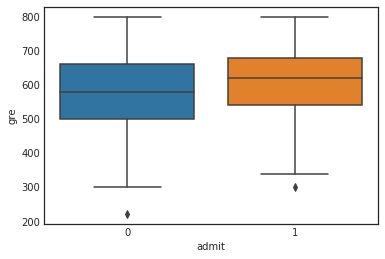

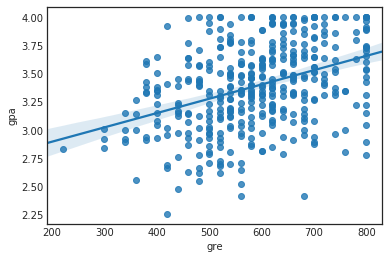

In [5]:
# Read in the data.
df = pd.read_csv("https://www.dropbox.com/s/qhf0ocdqb3gh7ni/logistic_regression.csv?dl=1") 

# Take a peek.
print(df.head())

# Prettier plots are better.
sns.set_style("white")

# Bivariate relationships of predictors to admissions outcome.
sns.boxplot(x="admit", y="gpa", data=df)
plt.show()
sns.boxplot(x="admit", y="gre", data=df)
plt.show()

# Relationship between predictors.
sns.regplot(x='gre', y='gpa', data=df)
plt.show()

Looks like our predictors may add some value, but they are also correlated with each other, which could cause some problems.  Let's go ahead:

In [6]:
# Declare predictors.
X_statsmod = df[['gre', 'gpa']]

# The Statsmodels formulation requires a column with constant value 1 that
# will act as the intercept.
X_statsmod['intercept'] = 1 

# Declare and fit the model.
logit = sm.Logit(df['admit'], X_statsmod)
result = logit.fit()

# Lots of information about the model and its coefficients, but the
# accuracy rate for predictions is missing.
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.600430
         Iterations 5
                        Results: Logit
Model:              Logit            No. Iterations:   5.0000  
Dependent Variable: admit            Pseudo R-squared: 0.039   
Date:               2018-04-22 17:31 AIC:              486.3440
No. Observations:   400              BIC:              498.3184
Df Model:           2                Log-Likelihood:   -240.17 
Df Residuals:       397              LL-Null:          -249.99 
Converged:          1.0000           Scale:            1.0000  
----------------------------------------------------------------
             Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
----------------------------------------------------------------
gre          0.0027    0.0011   2.5444  0.0109   0.0006   0.0048
gpa          0.7547    0.3196   2.3615  0.0182   0.1283   1.3811
intercept   -4.9494    1.0751  -4.6037  0.0000  -7.0565  -2.8422



/home/conner/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
# Calculate accuracy. First, get probability that each row will be admitted.
pred_statsmod = result.predict(X_statsmod)

# Code admission as 1 if probability is greater than .5.
pred_y_statsmod = np.where(pred_statsmod < .5, 0, 1)

# Accuracy table.
table = pd.crosstab(df['admit'], pred_y_statsmod)

print('\n Accuracy by admission status')
print(table)
print('\n Percentage accuracy')
print((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum()))


 Accuracy by admission status
col_0    0   1
admit         
0      263  10
1      118   9

 Percentage accuracy
0.68


## Fitting a binary logistic model using SKLearn

Unlike the statsmodels formulation, which just fits a standard binary logistic model that can be replicated using any other standard statistical software, the SKlearn logistic regression functionality includes a parameter regularization element that penalizes extremely large parameters in the name of increasing predictive accuracy.  We will talk more about this in the assignments on ridge and lasso regression, coming up next.  For now, the parameter "C" has been set to a very large number, which decreases the effectiveness of the regularization so that parameter estimates will be similar to the ones from 'statsmodels' above.

In [11]:
# Declare a logistic regression classifier.
# Parameter regularization coefficient C described above.
y = df['admit']
X = df[['gpa', 'gre']]
C=1e9
def lr_model(X, y, C):
    lr = LogisticRegression(C = C)

    # Fit the model.
    fit = lr.fit(X, y)

    # Display.
    print('Coefficients')
    print(fit.coef_)
    print(fit.intercept_)
    pred_y_sklearn = lr.predict(X)
    
    print('\n Accuracy by admission status')
    print(pd.crosstab(pred_y_sklearn, y))
    
    print('\n Percentage accuracy')
    print(lr.score(X, y))
lr_model(X,y,C)

Coefficients
[[0.74747563 0.00267019]]
[-4.91157158]

 Accuracy by admission status
admit    0    1
row_0          
0      263  118
1       10    9

 Percentage accuracy
0.68


## Challenge: optimize the model(s)

While the two packages yield similar accuracy rates, they have very different patterns of error.  Play with the models by adding additional features and shrinking the regularization coefficient to see if you can get the accuracy higher than 68%.  
<a id = 'challenge'></a>

In [22]:
# decrease C
C = 10
# modify features
from scipy import stats
X_feat = X.apply(stats.zscore)
X_feat['rank'] = df['rank']
# run model
lr_model(X_feat,y,C)

Coefficients
[[ 0.29495776  0.26463546 -0.55717158]]
[0.52538731]

 Accuracy by admission status
admit    0   1
row_0         
0      253  98
1       20  29

 Percentage accuracy
0.705


## Beyond Binary

What if we wanted to use regression to predict a categorical variable with more than two possible outcomes?  Then we can use _multinomial logistic regression_, of which _binary logistic regression_ is a special case.  (Which is to say, binary logistic regression is a type of multinomial logistic regression with only two possible outcomes.)  SKLearn can handle multinomial logistic regression without a hiccup – the code will be exactly the same as what we used above, only we would feed it an outcome variable $y$ with more than two categories.

What if we have an ordinal variable like where runners placed in a race?  We could treat it as continuous, but that would involve pretending that the distance between the 4th and 5th place finishers is the same size as the distance between the 44th and 45th place finishers.  We may not want to do that.  Instead, we can use _ordinal logistic regression_, which behaves like multinomial logistic regression but also incorporates information about the order of the categories.  If you ever need this functionality, the Python package [mord](http://pythonhosted.org/mord/) implements ordinal logistic regression in the style of SKlearn.